# Integration of multi-modal data using MultiVI

MultiVI `[Ashuach et al., 2021]` is used to integrate multiomic datasets with single-modality (expression or accessibility) datasets. We are going to generate a latent embedding of the multiomic datasets for each cell type.

## Setting up environment

In [1]:
import os
os.chdir('/home/yz979/code/kaggle-perturbation')
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import scvi
import scvi.model
import torch

torch.set_float32_matmul_precision('medium')

/home/yz979/miniconda3/envs/kaggle2/lib/python3.11/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/yz979/miniconda3/envs/kaggle2/lib/python3.11/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


## Loading dataset

The preprocessed Multiome dataset with `h5ad` extension used for saving/loading anndata objects can be loaded using the `sc.read_h5ad` function. The datasets is not normalized or preprocessed.

In [3]:
data_dir = 'data'
adata_mvi = sc.read_h5ad(os.path.join(data_dir, 'multiome_train.h5ad'))
n_genes = sum(adata_mvi.var['feature_type'] == 'Gene Expression')
n_regions = sum(adata_mvi.var['feature_type'] == 'Peaks')
adata_mvi.X = adata_mvi.X.toarray()

print('n_genes: ', n_genes)
print('n_regions: ', n_regions)
print(adata_mvi)

n_genes:  22787
n_regions:  135418
AnnData object with n_obs × n_vars = 25551 × 158205
    obs: 'cell_type', 'donor_id'
    var: 'gene_id', 'feature_type', 'genome', 'interval'


## Dataset setup
Now is the time to setup the dataset for `MultiVI` to prepare the dataset for training. Just like `scvi-tools` models, you can call `scvi.model.MULTIVI.setup_anndata` to setup your data. This function will accept the following arguments:

- `adata`: AnnData object containing the data to be preprocessed
- `batch_key`: The key in `adata.obs` that contains the batch information
- `categorical_covariate_keys`: A list of keys in `adata.obs` that contain categorical covariates
- `continuous_covariate_keys`: A list of keys in `adata.obs` that contain continuous covariates
- `protein_expression_obsm_key`: key in `adata.obsm` for protein expression data.
- `protein_names_uns_key`: key in `adata.uns` for protein names. If None, will use the column names of `adata.obsm[protein_expression_obsm_key]` if it is a DataFrame, else will assign sequential names to proteins.

In [4]:
scvi.model.MULTIVI.setup_anndata(adata_mvi, batch_key='donor_id')

<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## MultiVI Model

You can create a `MultiVI` model by creating an object from `scvi.model.MULTIVI` class. The constructor of this class takes the following arguments:

**Data related parameters:** 
- `adata`: AnnData object containing train/valid/test data

**Model architecture parameters:**
- `n_genes`: Number of genes in the expression data
- `n_regions`: Number of regions in the accessibility data 
- `n_latent`: Dimensionality of the latent space. If `None`, defaults to square root
        of `n_hidden`.
- `n_hidden`: Number of nodes per hidden layer. If `None`, defaults to square root
        of number of regions.
- `modality_weight`: Weighting scheme across modalities. One of the following:
   - ``"equal"``: Equal weight in each modality
   - ``"universal"``: Learn weights across modalities w_m.
   - ``"cell"``: Learn weights across modalities and cells. w_{m,c}
- `modality_penalty`: Training Penalty across modalities. One of the following:
   - ``"Jeffreys"``: Jeffreys penalty to align modalities
   - ``"MMD"``: MMD penalty to align modalities
   - ``"None"``: No penalty
- `dropout_rate`: Dropout rate for neural networks.
- `latent_distribution`: Distribution of the latent space. One of the following:
   - ``"normal"``: Normal distribution
   - ``"ln"``: Log-normal distribution
- `use_batch_norm`: Whether to use batch norm in the neural networks. Only of the following:
   - ``"none"``: No batch norm
   - ``"encoder"``: Batch norm in the encoder
   - ``"decoder"``: Batch norm in the decoder
   - ``"both"``: Batch norm in both encoder and decoder
- `use_layer_norm`: Whether to use layer norm in the neural networks. Only of the following:
   - ``"none"``: No layer norm
   - ``"encoder"``: Layer norm in the encoder
   - ``"decoder"``: Layer norm in the decoder
   - ``"both"``: Layer norm in both encoder and decoder

In [5]:
model_params = dict(
    n_genes = n_genes,
    n_regions = n_regions,
    n_latent = 64,
    n_hidden = 512,
    modality_weights = 'cell',
    modality_penalty = 'Jeffreys',
    gene_likelihood = 'zinb',
    use_batch_norm = 'none',
    use_layer_norm = 'both',
    latent_distribution = 'normal',
    dropout_rate = 0.1,
)
mvi = scvi.model.MULTIVI(adata_mvi, **model_params)

/home/yz979/miniconda3/envs/kaggle2/lib/python3.11/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


## Training MultiVI

In order to train your `MultiVI` model, you need to use `train` function of your `model`. This function accepts the following parameters:
- `max_epochs`: Maximum number of epochs to train the model. CPA generally converges after high number of epochs, so you can set this to a high value.
- `use_gpu`: If you have a GPU, you can set this to `True` to speed up the training process.
- `batch_size`: Batch size for training. You can set this to a high value (e.g. 512, 1024, 2048) if you have a GPU. 
- `lr`: Learning rate for training.
- `weight_decay`: Weight decay for training.
- `early_stopping`: Whether to use early stopping or not.
- `early_stopping_patience`: Number of epochs to wait before stopping training if validation metric does not improve.
- `check_val_every_n_epoch`: Number of epochs to wait before running validation.


In [10]:
train_params = dict(
    max_epochs = 500,
    lr = 1e-3,
    use_gpu = True,
    batch_size = 8,
    weight_decay = 1e-5,
    check_val_every_n_epoch = 1,
    early_stopping = True,
    save_best = True,
)
mvi.train(**train_params)
mvi.save('models/mvi', overwrite=True)

/home/yz979/miniconda3/envs/kaggle2/lib/python3.11/site-packages/scvi/train/_trainrunner.py:76: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 51/500:  10%|█         | 51/500 [1:00:35<8:53:26, 71.29s/it, v_num=1, train_loss_step=2.52e+4, train_loss_epoch=2.25e+4]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 22553.447. Signaling Trainer to stop.


## Restore best model

In case you have already saved your pretrained model, you can restore it using the following code. The `scvi.model.MULTIVI.load` function accepts the following arguments:
- `dir_path`: path to the directory where the model is saved
- `adata`: anndata object
- `use_gpu`: whether to use GPU or not


In [5]:
mvi: scvi.model.MULTIVI = scvi.model.MULTIVI.load('models/mvi', adata_mvi)

INFO     File models/mvi/model.pt already downloaded                                                               


/home/yz979/miniconda3/envs/kaggle2/lib/python3.11/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


## Latent Space Visualization

Latent vectors of all cells can be computed with `get_latent_representation` function.

In [6]:
adata_mvi.obsm['z'] = mvi.get_latent_representation()

In [7]:
sc.pp.neighbors(adata_mvi, use_rep='z', n_neighbors=30)
sc.tl.umap(adata_mvi, min_dist=0.1)

As observed below, the latent space of `MultiVI` is able to separate the cells based on their `cell type`. 

/home/yz979/miniconda3/envs/kaggle2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/yz979/miniconda3/envs/kaggle2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/yz979/miniconda3/envs/kaggle2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yz979/miniconda3/envs/kaggle2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatte

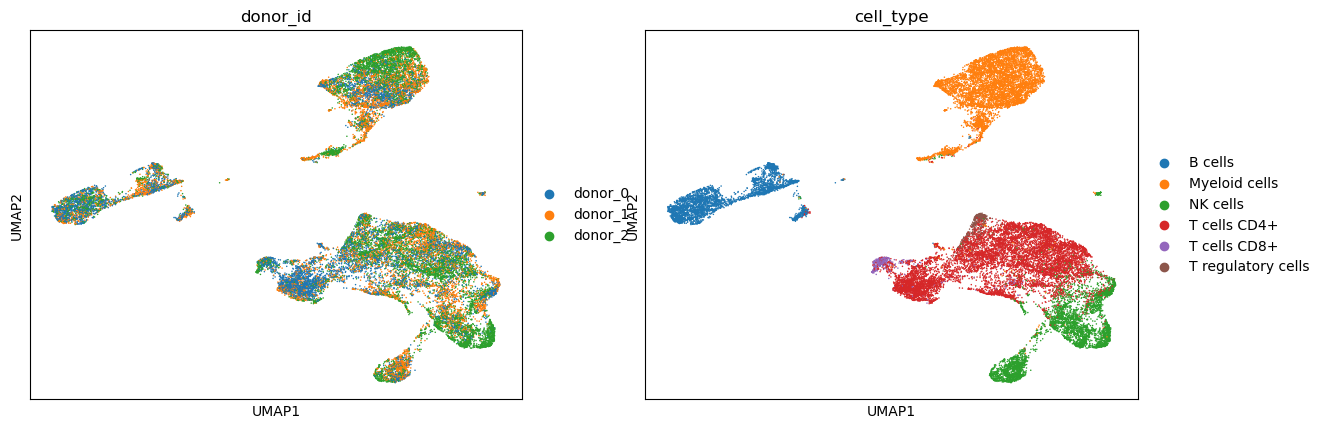

In [8]:
sc.pl.umap(adata_mvi, color=['donor_id', 'cell_type'], ncols=2)

## Get Average Latent Representation per Cell Type
Latent vectors of all cells can be computed with `get_latent_representation` function. We average the latent vectors of cells per cell type to get the average representation. The results are stored in `obsm` of both `de_train.h5ad` and `id_map.h5ad` files.

In [7]:
cell_groups = adata_mvi.obs.groupby('cell_type').groups
avg_latent = {}
for cell_type in cell_groups.keys():
    avg_latent[cell_type] = adata_mvi[cell_groups[cell_type]].obsm['z'].mean(axis=0)

/tmp/ipykernel_2648016/2867734899.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_groups = adata_mvi.obs.groupby('cell_type').groups


In [23]:
de_train = sc.read_h5ad(os.path.join(data_dir, 'de_train.h5ad'))
de_train.obsm['multivi'] = np.stack([avg_latent[cell_type] for cell_type in de_train.obs['cell_type']])
de_train.write_h5ad(os.path.join(data_dir, 'de_train.h5ad'))

In [8]:
id_map = sc.read_h5ad(os.path.join(data_dir, 'id_map.h5ad'))
id_map.obsm['multivi'] = np.stack([avg_latent[cell_type] for cell_type in id_map.obs['cell_type']])
id_map.write_h5ad(os.path.join(data_dir, 'id_map.h5ad'))